In [1]:
# Make maps of ensembles of runs with the same IC for exf variables
# Plots ensemble mean and the anomalies in each run relative to the EM

In [1]:
# from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import xarray as xr
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order
import matplotlib.path as mpath
import cartopy.crs as ccrs
from matplotlib import colors
import string

In [9]:
# Configure data options

exp_set = 'ic_2001'
region = 'AS_near'

# Order to plot 10 forcings
# plot_runs = exp_set_dict_warm_order[exp_set] #f rom warm to cool ocean conditions
runs = exp_set_dict_wind_order[exp_set] # from shelf break westerly to easterly  
print('Plotting runs in this order:\n',plot_runs)


Plotting runs in this order:
 ['run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']


In [5]:
# Load ensemble of winds as anomalies relative ens mean

uwind_fname = '../Saved Arrays/Ensemble_data/Forcing_uwind_anom_ann_mean_'+exp_set+'_'+region+'.nc'
vwind_fname = '../Saved Arrays/Ensemble_data/Forcing_vwind_anom_ann_mean_'+exp_set+'_'+region+'.nc'

# try loading presaved wind anomaly datasets
try:
    print('presaved u and vwind datasets found')
    uwind_ds = xr.open_dataset(uwind_fname)
    vwind_ds = xr.open_dataset(vwind_fname)
    all_run_uwind_anom = uwind_ds.uwind
    all_run_vwind_anom = vwind_ds.vwind

# if files do not exist, load ensemble wind data and calculate anomalies
except:
    # load ens data
    all_run_uwind_da = fda.get_ensemble_data_for_ic('uwind', runs, region, 'EXF_forcing_set2', n_months = 12) 
    all_run_vwind_da = fda.get_ensemble_data_for_ic('vwind', runs, region, 'EXF_forcing_set2', n_months = 12) 
    # get ens mean and calculate time-average
    uwind_em = all_run_uwind_da.mean(dim = 'run')
    uwind_em_time_avg = uwind_em.mean(dim = 'time')
    vwind_em = all_run_vwind_da.mean(dim = 'run')
    vwind_em_time_avg = vwind_em.mean(dim = 'time')    
    # get time-average of ens winds and put in anoms relative to em
    uwind_time_avg = all_run_uwind_da.mean(dim='time')  #(n_runs,n_lats,n_lons)
    all_run_uwind_anom = uwind_time_avg - uwind_em_time_avg #xr da with shape (10 runs, n_lats,n_lons)
    vwind_time_avg = all_run_vwind_da.mean(dim='time')
    all_run_vwind_anom = vwind_time_avg - vwind_em_time_avg 
    # save data arrays
    uwind_ds = uwind_anom.to_dataset(name='uwind')
    uwind_ds.to_netcdf(uwind_fname)
    vwind_ds = vwind_anom.to_dataset(vname='vwind')
    vwind_ds.to_netcdf(vwind_fname)
    print('datasets saved as',uwind_fname,vwind_fname)

# all_run_uwind_anom

presaved u and vwind datasets found


In [6]:
# Get ocean temp ensemble data at 400m depth for full 5 years

# Load all 5 years of data
t_fname = '../Saved Arrays/Ensemble_data/T_400m_'+exp_set+'_'+region+'_60_months.nc'
try:
    t_ds = xr.open_dataset(t_fname) #shape (n_runs, n_times, n_lats, n_lons)
    all_run_T = t_ds.T
    print('precalc T ds found')
except:
    all_run_T = fda.get_ensemble_data_for_ic('T', runs, region, 'state_3d_set2', month_start_idx = 0, n_months = 60, depth = -400) 
    t_ds = all_run_t_da.to_dataset(name='T')
    t_ds.to_netcdf(t_fname)
    print('T saved as',t_fname)



precalc T ds found


In [7]:
# get 5th year mean and put in anomalies relative to ens mean (averaged over all 5 years)

all_run_T_yr5 = all_run_T.isel(time=slice(47,59))
all_run_T_yr5_mean = all_run_T_yr5.mean(dim='time') #shape (n_runs,n_lats,n_lons)
T_all_5_yrs = all_run_T.mean(dim='time')
em_T_all_5_yrs = T_all_5_yrs.mean(dim='run')
ens_T_anom_yr5 = all_run_T_yr5_mean - em_T_all_5_yrs
# ens_T_anom_yr5

0 run_forc_erai_2015_rep_ic_2001
1 run_forc_erai_1991_rep_ic_2001
2 run_forc_erai_1982_rep_ic_2001
3 run_forc_erai_1994_rep_ic_2001
4 run_forc_erai_1992_rep_ic_2001
5 run_forc_erai_1984_rep_ic_2001
6 run_forc_erai_2009_rep_ic_2001
7 run_forc_erai_2003_rep_ic_2001
8 run_forc_erai_1989_rep_ic_2001
9 run_forc_erai_2011_rep_ic_2001
Saving figure as Plots/Figure_1c_wind_forcings.png


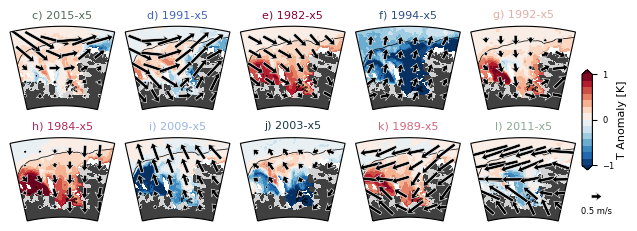

In [14]:
# Plot full ensemble maps 
save = False

# assign data, each with same shape (n_runs, n_lats, n_lons)
data_x = all_run_uwind_anom
data_y = all_run_vwind_anom
color_data = ens_T_anom_yr5

# set up metadata
n_runs = len(runs)
levs = np.linspace(-1,1,15)
cmap = 'RdBu_r'
vec_len = 0.5 #m/s
colors_dict =  {'1982_x5':"#850033",
                '1984_x5':"#b22a57",
                '1989_x5':"#d0677e",
                '1992_x5':"#e2ada6",
                '2011_x5':"#8AA894",
                '2015_x5':"#4E6A58",
                '2009_x5':"#9ab5e5",
                '1991_x5':"#4263bd",
                '1994_x5':"#2d4d81",
                '2003_x5':"#173645"}

# Set up plot
lons, lats = color_data.lon, color_data.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
rows,cols = 2, 5
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((6.5,2.5))


# Plot each run in ensemble
for i in range(n_runs):
    run = runs[i]
    print(i, run)
    run_color_data = color_data.sel(run = run)
    run_quiv_data_x = data_x.sel(run = run)
    run_quiv_data_y = data_y.sel(run = run)
    
    # Plot and mask 0 values so they are not plotted as colors
    run_color_data_masked = run_color_data.where(run_color_data != 0)
    ax = fig.add_subplot(rows, cols, i+1, projection= ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
    cf = ax.contourf(lons, lats, run_color_data_masked, transform=grid_proj, levels=levs, cmap=cmap, zorder=0, 
                     extend='both')
    title_i = f'{string.ascii_lowercase[i+2]}) '+run.split('_')[3]+'-x5'
    plt.title(title_i,fontsize=8,color=colors_dict[run.split('_')[3]+'_x5'])
        
    data_x_masked = run_quiv_data_x.where(run_quiv_data_x != 0)
    data_y_masked = run_quiv_data_y.where(run_quiv_data_y != 0)
    q_lon,q_lat = data_x_masked.lon.values, data_x_masked.lat.values
    quiv = ax.quiver(q_lon,q_lat, data_x_masked.values, data_y_masked.values, transform = grid_proj, 
                     regrid_shape=7, pivot = 'middle', scale=5, width=0.03, headlength=2,
                     headaxislength=1.5, minshaft=1, edgecolor='white', linewidth = 0.4,zorder=3) 
ax.quiverkey(quiv, X=1.2, Y=0.3, U=vec_len, label=str(vec_len)+' m/s', labelpos='S', 
             fontproperties={'size': 6})
        
# Add bathymetry and ice to all subplots
land_ice_ds = fda.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (1000,)

for ax in fig.get_axes():

    # Plot bathymetry and ice
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=0.5,zorder=1)
    white_cm = colors.ListedColormap(("lightgray","lightgray"))
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,cmap=white_cm,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map to match shape of data
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

    
fig.subplots_adjust(left=0.01,right=0.88,top=0.92,bottom=0.05,wspace=0.1,hspace=.05)


# Add colorbar for runs
cb_ax = fig.add_axes([0.89,0.3,0.016,0.4])
cb = fig.colorbar(cf, cax=cb_ax, extend='both',orientation = 'vertical')
cb.set_label(label = 'T Anomaly [K]', fontsize=8,labelpad=2)
cb.ax.tick_params(labelsize=6)
cb.set_ticks([-1,0,1])

if save:
    fname = 'Plots/Figure_1c_wind_forcings_wind_order.png'
    plt.savefig(fname, bbox_inches='tight', dpi=400)
    print('Saving figure as',fname)


0 run_forc_erai_1982_rep_ic_2001
1 run_forc_erai_1984_rep_ic_2001
2 run_forc_erai_1989_rep_ic_2001
3 run_forc_erai_1992_rep_ic_2001
4 run_forc_erai_2011_rep_ic_2001
5 run_forc_erai_2015_rep_ic_2001
6 run_forc_erai_2009_rep_ic_2001
7 run_forc_erai_1991_rep_ic_2001
8 run_forc_erai_2003_rep_ic_2001
9 run_forc_erai_1994_rep_ic_2001
Saving figure as Plots/Figure_1c_wind_forcings_warm_order.png


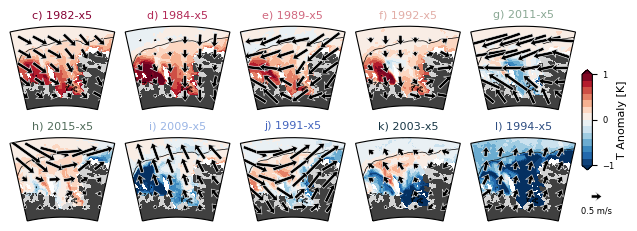

In [19]:
# Plot full ensemble maps 
runs = [ 'run_forc_erai_1982_rep_ic_2001',
         'run_forc_erai_1984_rep_ic_2001',
         'run_forc_erai_1989_rep_ic_2001',
         'run_forc_erai_1992_rep_ic_2001',
         'run_forc_erai_2011_rep_ic_2001',
         'run_forc_erai_2015_rep_ic_2001',
         'run_forc_erai_2009_rep_ic_2001',
         'run_forc_erai_1991_rep_ic_2001',
         'run_forc_erai_2003_rep_ic_2001',
         'run_forc_erai_1994_rep_ic_2001']
save = False

# assign data, each with same shape (n_runs, n_lats, n_lons)
data_x = all_run_uwind_anom
data_y = all_run_vwind_anom
color_data = ens_T_anom_yr5

# set up metadata
n_runs = len(runs)
levs = np.linspace(-1,1,15)
cmap = 'RdBu_r'
vec_len = 0.5 #m/s
colors_dict =  {'1982_x5':"#850033",
                '1984_x5':"#b22a57",
                '1989_x5':"#d0677e",
                '1992_x5':"#e2ada6",
                '2011_x5':"#8AA894",
                '2015_x5':"#4E6A58",
                '2009_x5':"#9ab5e5",
                '1991_x5':"#4263bd",
                '1994_x5':"#2d4d81",
                '2003_x5':"#173645"}

# Set up plot
lons, lats = color_data.lon, color_data.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
rows,cols = 2, 5
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((6.5,2.5))


# Plot each run in ensemble
for i in range(n_runs):
    run = runs[i]
    print(i, run)
    run_color_data = color_data.sel(run = run)
    run_quiv_data_x = data_x.sel(run = run)
    run_quiv_data_y = data_y.sel(run = run)
    
    # Plot and mask 0 values so they are not plotted as colors
    run_color_data_masked = run_color_data.where(run_color_data != 0)
    ax = fig.add_subplot(rows, cols, i+1, projection= ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
    cf = ax.contourf(lons, lats, run_color_data_masked, transform=grid_proj, levels=levs, cmap=cmap, zorder=0, 
                     extend='both')
    title_i = f'{string.ascii_lowercase[i+2]}) '+run.split('_')[3]+'-x5'
    plt.title(title_i,fontsize=8,color=colors_dict[run.split('_')[3]+'_x5'])
        
    data_x_masked = run_quiv_data_x.where(run_quiv_data_x != 0)
    data_y_masked = run_quiv_data_y.where(run_quiv_data_y != 0)
    q_lon,q_lat = data_x_masked.lon.values, data_x_masked.lat.values
    quiv = ax.quiver(q_lon,q_lat, data_x_masked.values, data_y_masked.values, transform = grid_proj, 
                     regrid_shape=7, pivot = 'middle', scale=5, width=0.03, headlength=2,
                     headaxislength=1.5, minshaft=1, edgecolor='white', linewidth = 0.4,zorder=3) 
ax.quiverkey(quiv, X=1.2, Y=0.3, U=vec_len, label=str(vec_len)+' m/s', labelpos='S', 
             fontproperties={'size': 6})
        
# Add bathymetry and ice to all subplots
land_ice_ds = fda.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (1000,)

for ax in fig.get_axes():

    # Plot bathymetry and ice
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=0.5,zorder=1)
    white_cm = colors.ListedColormap(("lightgray","lightgray"))
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,cmap=white_cm,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map to match shape of data
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

    
fig.subplots_adjust(left=0.01,right=0.88,top=0.92,bottom=0.05,wspace=0.1,hspace=.05)


# Add colorbar for runs
cb_ax = fig.add_axes([0.89,0.3,0.016,0.4])
cb = fig.colorbar(cf, cax=cb_ax, extend='both',orientation = 'vertical')
cb.set_label(label = 'T Anomaly [K]', fontsize=8,labelpad=2)
cb.ax.tick_params(labelsize=6)
cb.set_ticks([-1,0,1])

if save:
    fname = 'Plots/Figure_1c_wind_forcings_warm_order.png'
    plt.savefig(fname, bbox_inches='tight', dpi=400)
    print('Saving figure as',fname)
